<font size='6'><b>CosmoGridV1 for DES: tutorial</b></font>

# Goals of the tutorial:

* Plot cosmologies and baryon parameters on the grid
* Download, load and plot maps from CosmoGridV1
* Use raw shells, projected probe maps, and TFRecords

# Imports

In [1]:
import sys, os, h5py, bz2, pylab as plt, importlib, itertools, pandas as pd, healpy as hp
from tqdm.auto import tqdm, trange
from collections import OrderedDict
from IPython.display import set_matplotlib_formats
import seaborn
from ipywidgets import interactive, fixed, widgets
set_matplotlib_formats('retina')
# plt.style.use('dark_background')
plt.style.use('default')
%pylab inline
%load_ext autoreload
%autoreload 2
if 'notebooks' in os.getcwd(): os.chdir('..')
print(os.getcwd())

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
/Users/tomaszk/Archive/projects/220708_cosmogrid_paper/013_quadbias_limber


/var/folders/96/4c5n4tpd02l_82z2ppsmr5_40000gn/T/ipykernel_4638/1990916239.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
/Users/tomaszk/pyvenv/miniconda3/envs/tfm1231030/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Connection parameters

In [2]:
host = 'perlmutter'

# Plot distribution of cosmologies on the grid

In [3]:
def load_metadata(sim_type):

    with h5py.File('CosmoGridV1_metainfo.h5', 'r') as f:
        sims = np.array(f[f'simulations/{sim_type}'])
    return sims

In [4]:
def scatter_grid(pars, title='', **kw):
    
    nx, ny = len(pars)-1, len(pars); figsize=2; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
    for i in range(0, len(pars)):
        for j in range(0, len(pars)-1):
            ax[j,i].axis('off')
    for i in range(0, len(pars)):
        for j in range(i+1, len(pars)):
            ax[j-1,i].axis('on')
            ax[j-1,i].scatter(x=params_plot[pars[i]], y=params_plot[pars[j]], **kw)
            ax[j-1,i].set(xlabel=pars[i], ylabel=pars[j])
    
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    fig.suptitle(title, y=0.8, fontsize=20)

In [5]:
! rsync -avRh --progress {host}:/global/cfs/cdirs/des/cosmogrid/./CosmoGridV1_metainfo.h5 .

receiving file list ... 
1 file to consider

sent 16 bytes  received 103 bytes  79.33 bytes/sec
total size is 12.26M  speedup is 102990.72


In [6]:
sims = load_metadata('grid')

In [7]:
pars = ['Om', 's8', 'H0', 'Ob', 'ns', 'w0', 'bary_Mc', 'bary_nu']
params_plot = pd.DataFrame(sims[pars])

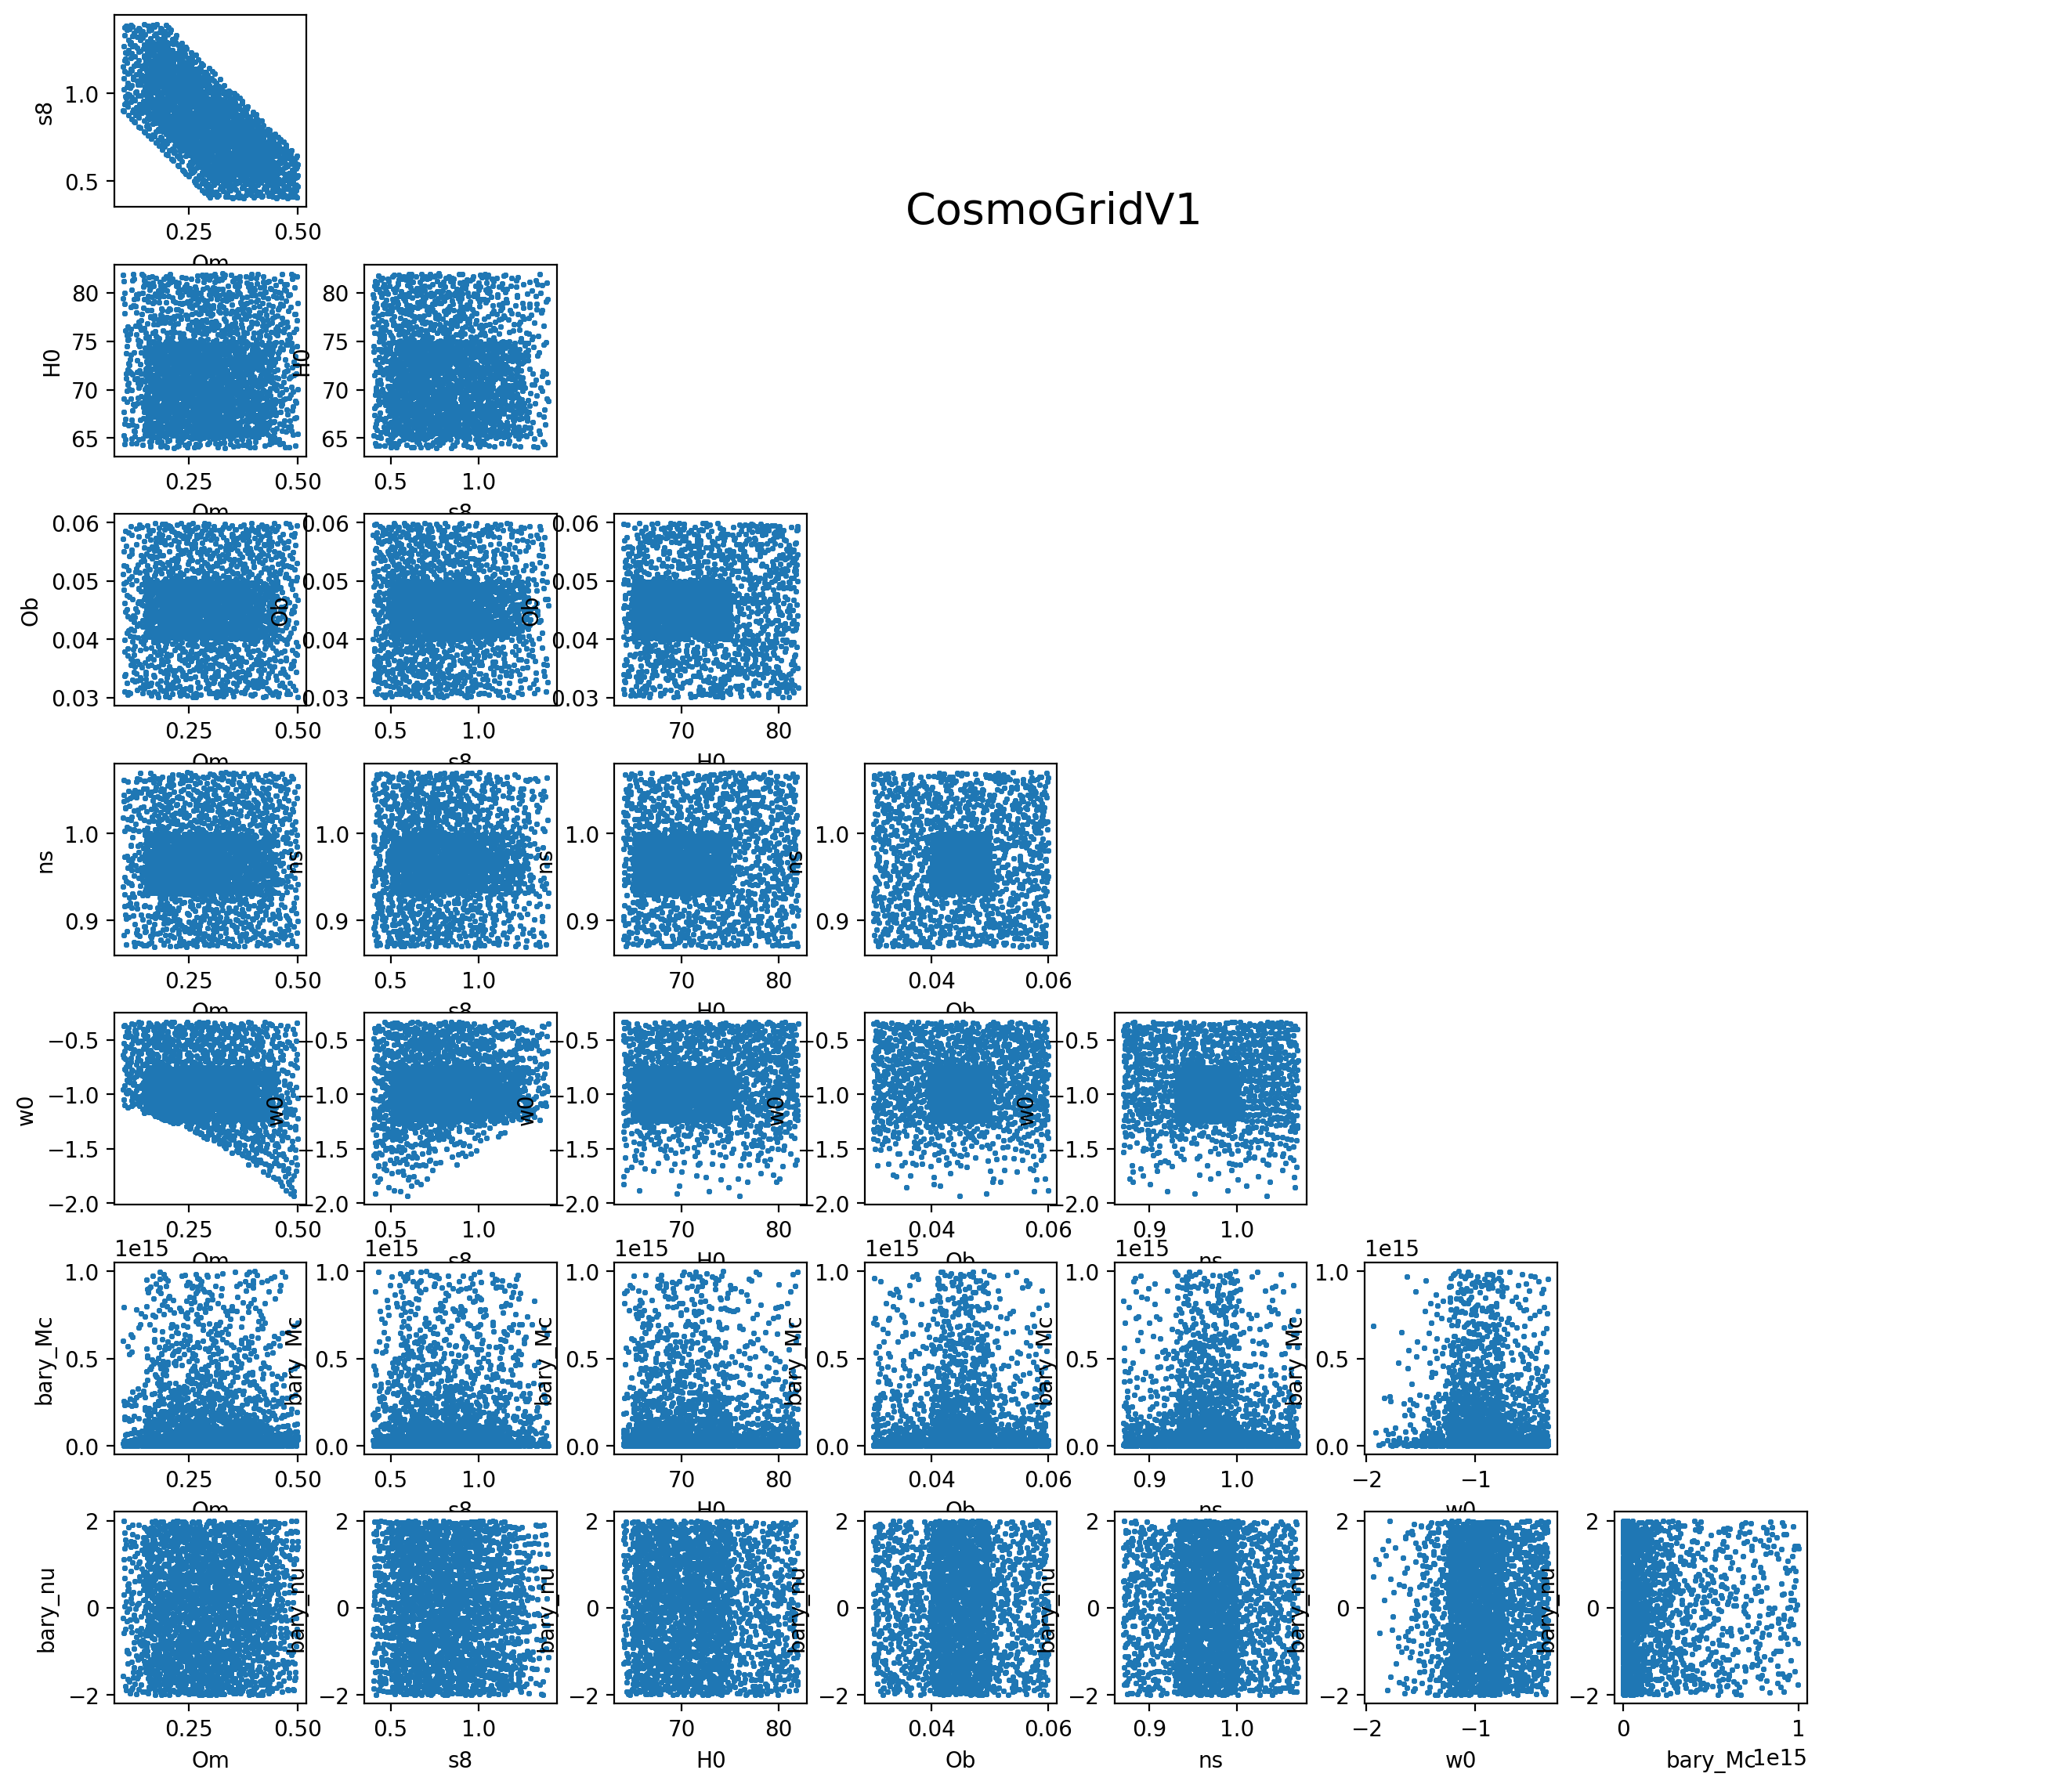

In [8]:
scatter_grid(pars, s=2, title='CosmoGridV1')

## Get shell boundaries

In [9]:
def load_shelldata(sim):

    with h5py.File('CosmoGridV1_metainfo.h5', 'r') as f:
        path = f'shell_info/CosmoGrid/raw/{sim}'
        shells = np.array(f[path])
        # shells = np.array(f['shell_info
    return shells

In [10]:
shellinfo = load_shelldata(sim='fiducial/cosmo_fiducial')

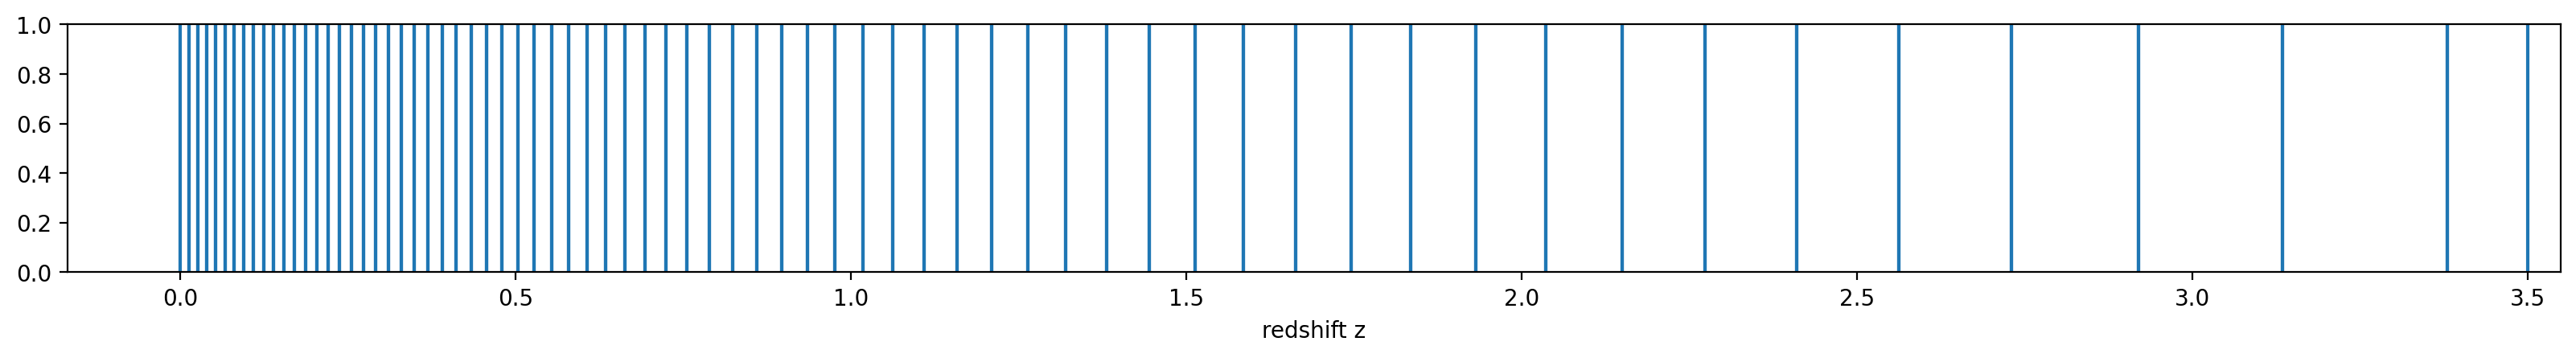

In [11]:
nx, ny = 1, 1; figsize=2; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 10, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
for s in shellinfo:
    axc.axvline(s['lower_z'])
    axc.axvline(s['upper_z'])
axc.set(xlabel='redshift z');

# Plot raw CosmoGridV1 shells

In [12]:
def smooth(m, sig_arcmin=8):
    
    if sig_arcmin>0:
        m = hp.smoothing(m, sigma=np.deg2rad(sig_arcmin/60))
    
    return m
    
def downsample(m, nside):
    return hp.ud_grade(m, nside_out=nside, power=-2)

def plot_map(m, title=''):

    vmin, vmax = np.percentile(m, [5, 95])
    nx, ny = 1, 1; figsize=8; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')

    hp.orthview(m, cmap='plasma', bgcolor='white', hold=True, title=title, half_sky=True, min=vmin, max=vmax, fig=fig)

def plot_shell(i, shells):
    z = (shellinfo['lower_z'][i]+shellinfo['upper_z'][i])/2.
    plot_map(shells[i], title=f'z={z:2.3f}')
    

## Raw unbaryonified shells

In [13]:
def load_compressed_shells(path):
    
    with np.load(path) as f:
        shells = np.array(f['shells'])
    
    return shells

In [14]:
def to_lowres(shells, nside=512, sig_smooth_arcmin=5):
    
    shells_smooth = np.zeros((len(shells), hp.nside2npix(nside)))
    for i in trange(len(shells), desc='downsampling and smoothing shells'):
        shells_smooth[i] = downsample(shells[i], nside=nside)
        shells_smooth[i] = smooth(shells_smooth[i], sig_arcmin=sig_smooth_arcmin)
    
    return shells_smooth

In [15]:
! rsync -avRh --progress {host}:/global/cfs/cdirs/des/cosmogrid/./raw/fiducial/cosmo_fiducial/run_0/compressed_shells.npz .

receiving file list ... 
5 files to consider

sent 16 bytes  received 192 bytes  83.20 bytes/sec
total size is 3.15G  speedup is 15137732.45


In [32]:
nside=256
sig_smooth_arcmin=10

In [33]:
shells_dmo = load_compressed_shells('raw/fiducial/cosmo_fiducial/run_0/compressed_shells.npz')
shells_dmo = to_lowres(shells_dmo, nside=nside, sig_smooth_arcmin=sig_smooth_arcmin)

downsampling and smoothing shells:   0%|          | 0/69 [00:00<?, ?it/s]

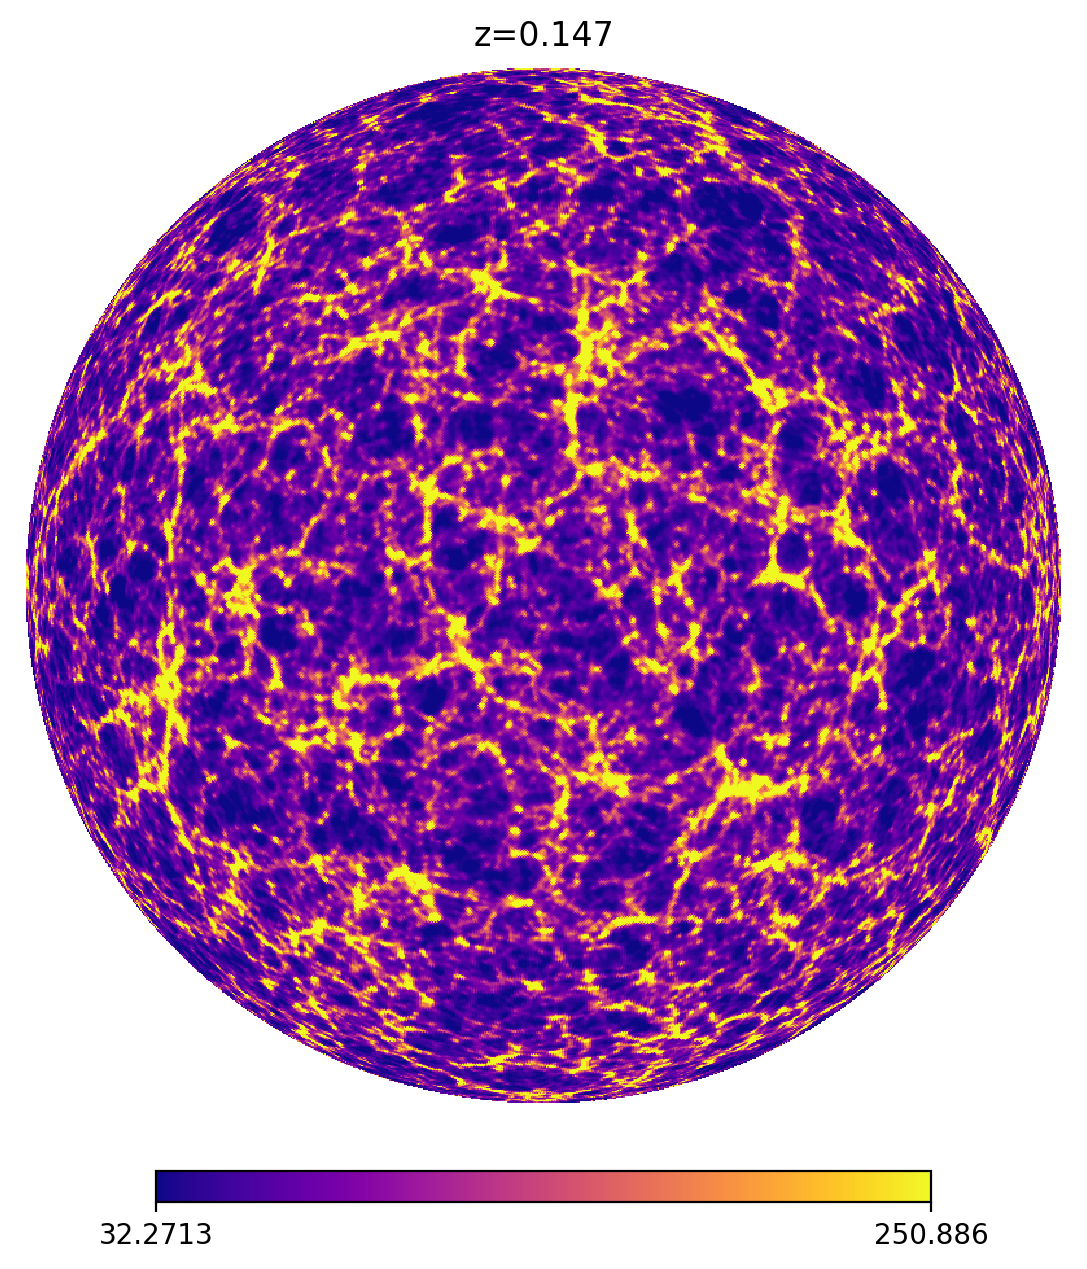

In [34]:
plot_shell(10, shells_dmo)

In [ ]:
from ipywidgets import interactive, widgets
interactive_plot = interactive(plot_shell, i=widgets.IntSlider(min=0, max=68, step=1, value=0), shells=fixed(shells_dmo))
interactive_plot

## Raw baryonified shells

In [35]:
! rsync -avRh --progress {host}:/global/cfs/cdirs/des/cosmogrid/./raw/fiducial/cosmo_fiducial/run_0/baryonified_shells.npz .

receiving file list ... 
5 files to consider

sent 16 bytes  received 185 bytes  80.40 bytes/sec
total size is 649.82M  speedup is 3232943.70


In [36]:
def load_compressed_baryonified_shells(path):
    
    with np.load(path) as f:
        sorting = np.argsort(np.array(f['shell_info'])['shell_id'])
        shells = np.array(f['shells'])[sorting]
    
    return shells

In [37]:
shells_dmb = load_compressed_baryonified_shells('raw/fiducial/cosmo_fiducial/run_0/baryonified_shells.npz')
shells_dmb = to_lowres(shells_dmb, nside=nside, sig_smooth_arcmin=sig_smooth_arcmin)

downsampling and smoothing shells:   0%|          | 0/69 [00:00<?, ?it/s]

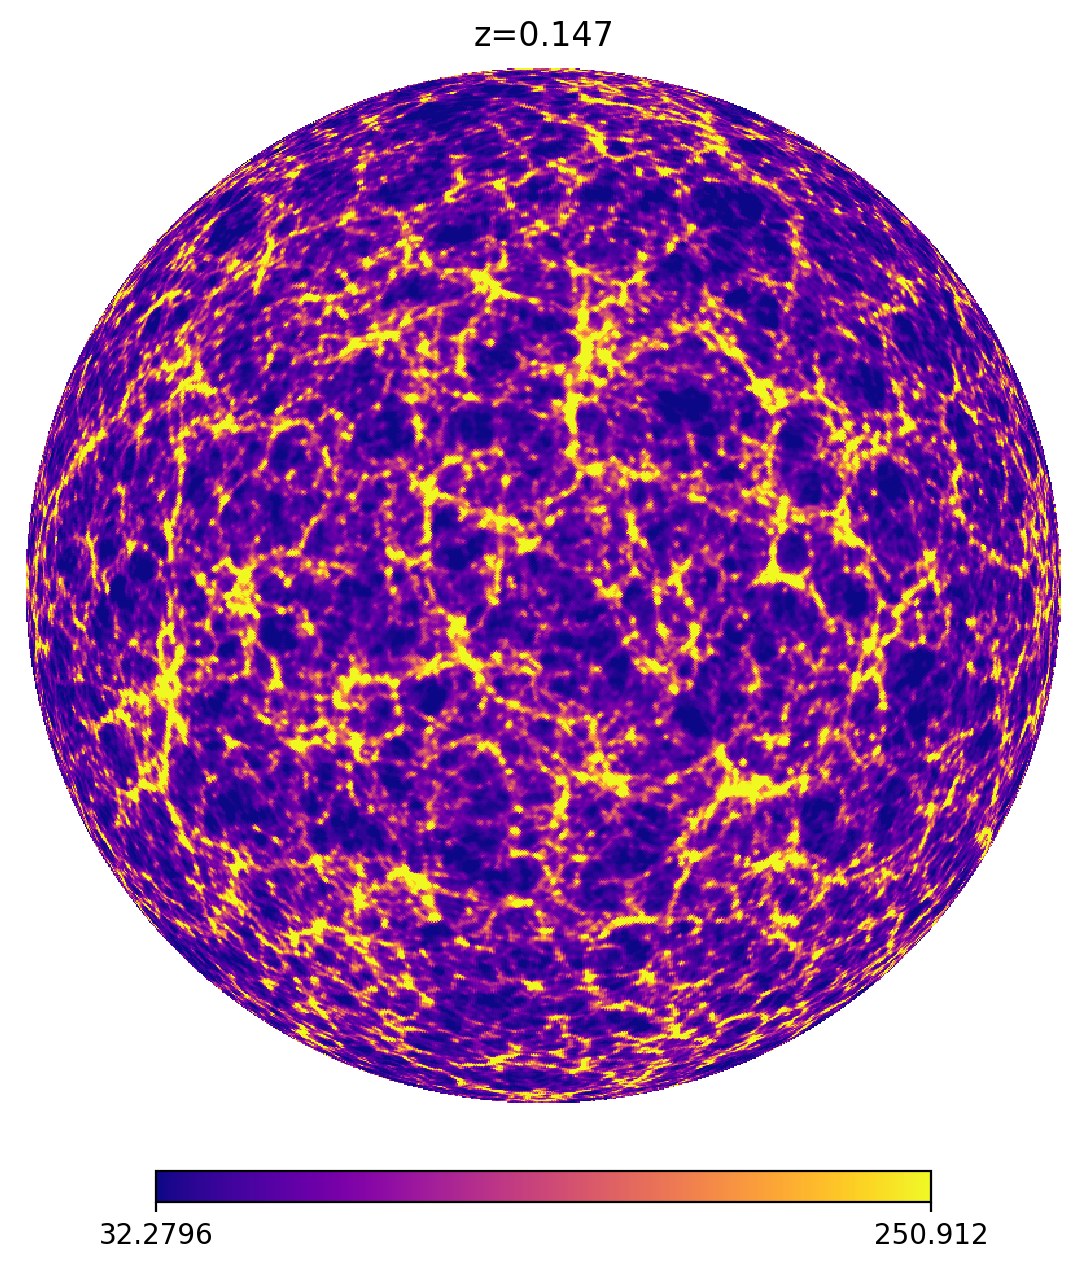

In [38]:
plot_shell(10, shells_dmb)

In [ ]:
from ipywidgets import interactive, widgets
interactive_plot = interactive(plot_shell, i=widgets.IntSlider(min=0, max=68, step=1, value=0), shells=fixed(shells_dmb))
interactive_plot

# DES Y3 probe maps

Let's use the fiducial cosmology, permutation 0000

In [39]:
! rsync -avRh --progress {host}:/global/cfs/cdirs/des/cosmogrid/./DESY3/fiducial/cosmo_fiducial/perm_0000 .

receiving file list ... 
7 files to consider

sent 16 bytes  received 290 bytes  122.40 bytes/sec
total size is 360.58M  speedup is 1178365.41


## Get info about the permutation

In [40]:
def load_permutation_index(dirname):
    
    with h5py.File(f'{dirname}/shell_permutations_index.h5', 'r') as f:
        shell_groups = np.array(f['shell_groups'])
        perms_info = np.array(f['perms_info'])

    return shell_groups, perms_info

In [41]:
shell_groups, perm_info = load_permutation_index('DESY3/fiducial/cosmo_fiducial/perm_0000/')

Simulations that were used to create this lightcone. 

`id_sim: ` ` simulation id, example: ``run_0``

`rot`:  rotation index -- there are four healpix symmetries that match pixels exactly by shape, no need to resample

`flip_ud`, `flip_lr` -- flip up-down or left-right

In [42]:
pd.DataFrame(perm_info)

id_sim  rot  flip_ud  flip_lr
0      96    3        0        1
1      63    0        1        1
2     168    2        0        1
3     196    2        0        0
4      68    3        1        1
5       9    1        1        0

$\rightarrow$ 5 independent simulations were used to create this lightcone up to z=3.5

## Plot maps 

In [43]:
probe_tags= {'kg': 'weak lensing', 'dg': 'galaxy clustering', 'ia': 'intrinsic alignment'}

In [44]:
def load_projected_maps(dirname, tag='nobaryons', sig_smooth_arcmin=5, verb=False):

    all_samples = []
    maps = {}
    with h5py.File(f'{dirname}/projected_probes_maps_{tag}512.h5', 'r') as f:
        probes = list(f.keys())
        for probe in probes:
            maps[probe] = {}
            probe_tag = probe_tags[probe]
            samples = f[probe].keys()
            all_samples.extend(samples)
            for sample in samples:
                
                if verb:
                    print(f'probe = {probe_tag:<25s}  sample = {sample:>10s}')
                
                maps[probe][sample] = smooth(np.array(f[probe][sample]), sig_arcmin=sig_smooth_arcmin)

                # hp.write_map(f'map_{probe}_{sample}.fits', maps[probe][sample], fits_IDL=False)
                    
    return maps, probes, sort(list(set(all_samples)))[::-1]

In [45]:
def plot_map(m, title=''):

    nx, ny = 1, 1; figsize=8; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
    vmin, vmax = np.percentile(m, [5, 95])
    m_ = smooth(m)
    hp.orthview(m_, cmap='plasma', bgcolor='white', hold=True, title=title, half_sky=True, min=vmin, max=vmax)

def plot_probe_map(probe, sample, maps, tag=''):

    if probe in maps.keys():
        if sample in maps[probe].keys():
            plot_map(maps[probe][sample], title=f'{tag} {probe_tags[probe]} {sample}')
        else:
            nx, ny = 1, 1; figsize=8; fig, ax  = plt.subplots(nx, ny, figsize=(ny * figsize * 1.25, nx * figsize), squeeze=False); axl=ax.ravel(); axc=ax[0,0];  fig.set_label(' ')
            axc.set(title=f'{probe_tags[probe]} {sample} map not available')
            axc.axis('off')

In [47]:
maps_dmo, probes, all_samples = load_projected_maps('DESY3/fiducial/cosmo_fiducial/perm_0000/', 'nobaryons', verb=True, sig_smooth_arcmin=sig_smooth_arcmin)

probe = galaxy clustering          sample = desy3maglim1
probe = galaxy clustering          sample = desy3maglim2
probe = galaxy clustering          sample = desy3maglim3
probe = galaxy clustering          sample = desy3maglim4
probe = galaxy clustering          sample = desy3maglim5
probe = galaxy clustering          sample = desy3maglim6
probe = galaxy clustering          sample = desy3metacal1
probe = galaxy clustering          sample = desy3metacal2
probe = galaxy clustering          sample = desy3metacal3
probe = galaxy clustering          sample = desy3metacal4
probe = intrinsic alignment        sample = desy3metacal1
probe = intrinsic alignment        sample = desy3metacal2
probe = intrinsic alignment        sample = desy3metacal3
probe = intrinsic alignment        sample = desy3metacal4
probe = weak lensing               sample = desy3metacal1
probe = weak lensing               sample = desy3metacal2
probe = weak lensing               sample = desy3metacal3
probe = weak lensing

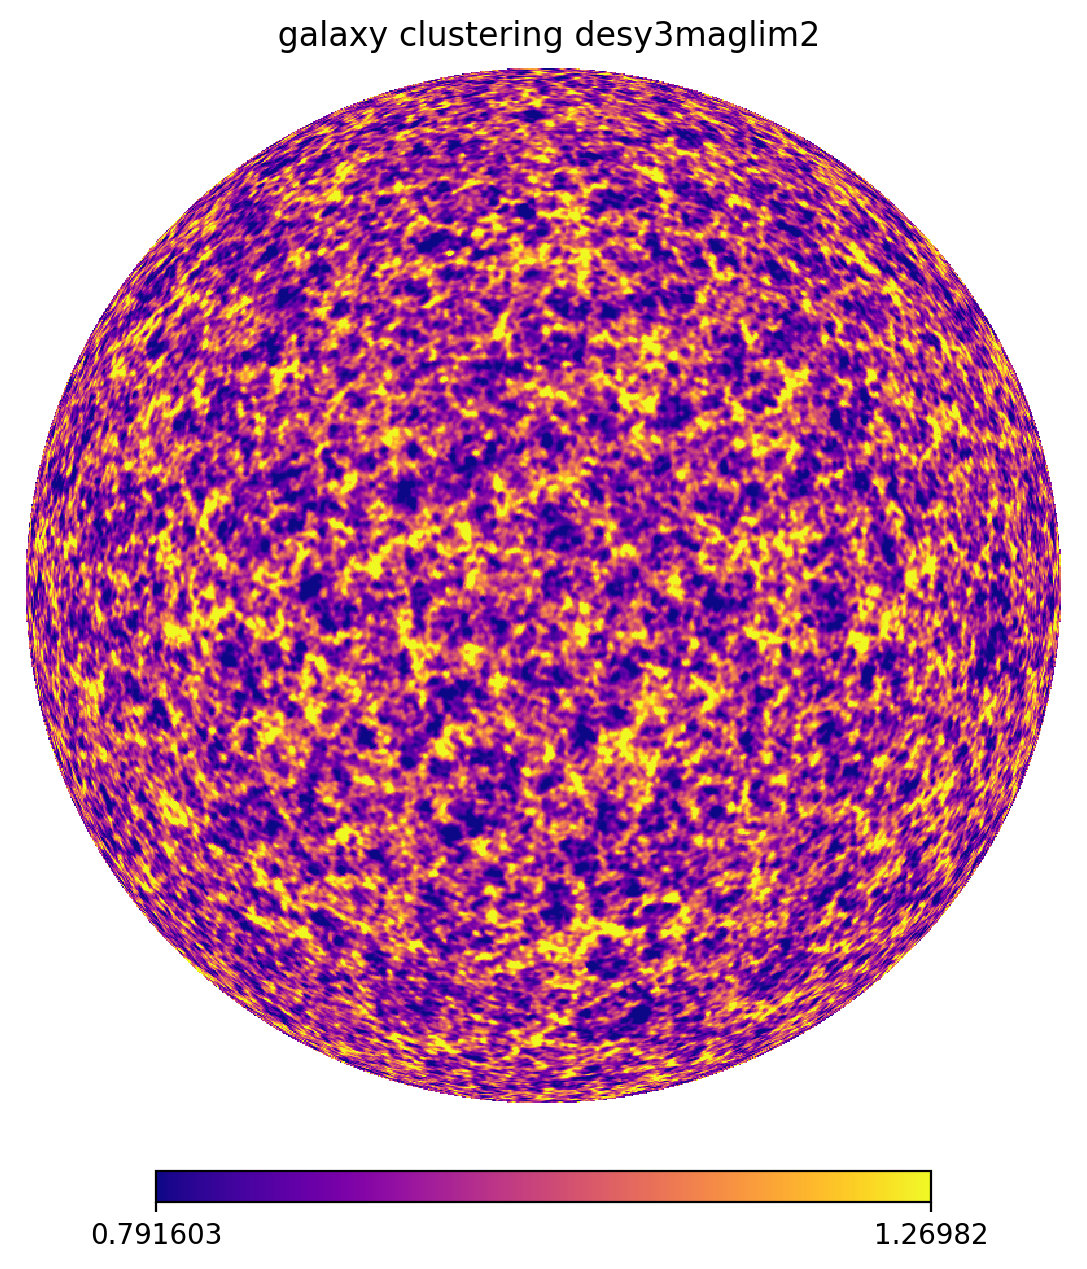

In [48]:
plot_probe_map('dg', 'desy3maglim2', maps_dmo)

In [ ]:
from ipywidgets import interactive, widgets
interactive_plot = interactive(plot_probe_map, probe=probes, sample=all_samples, maps=fixed(maps_dmo), tag=fixed('dmo'))
interactive_plot

## for baryonified maps

In [49]:
maps_dmb, probes, all_samples = load_projected_maps('DESY3/fiducial/cosmo_fiducial/perm_0000/', 'baryonified', sig_smooth_arcmin=sig_smooth_arcmin)

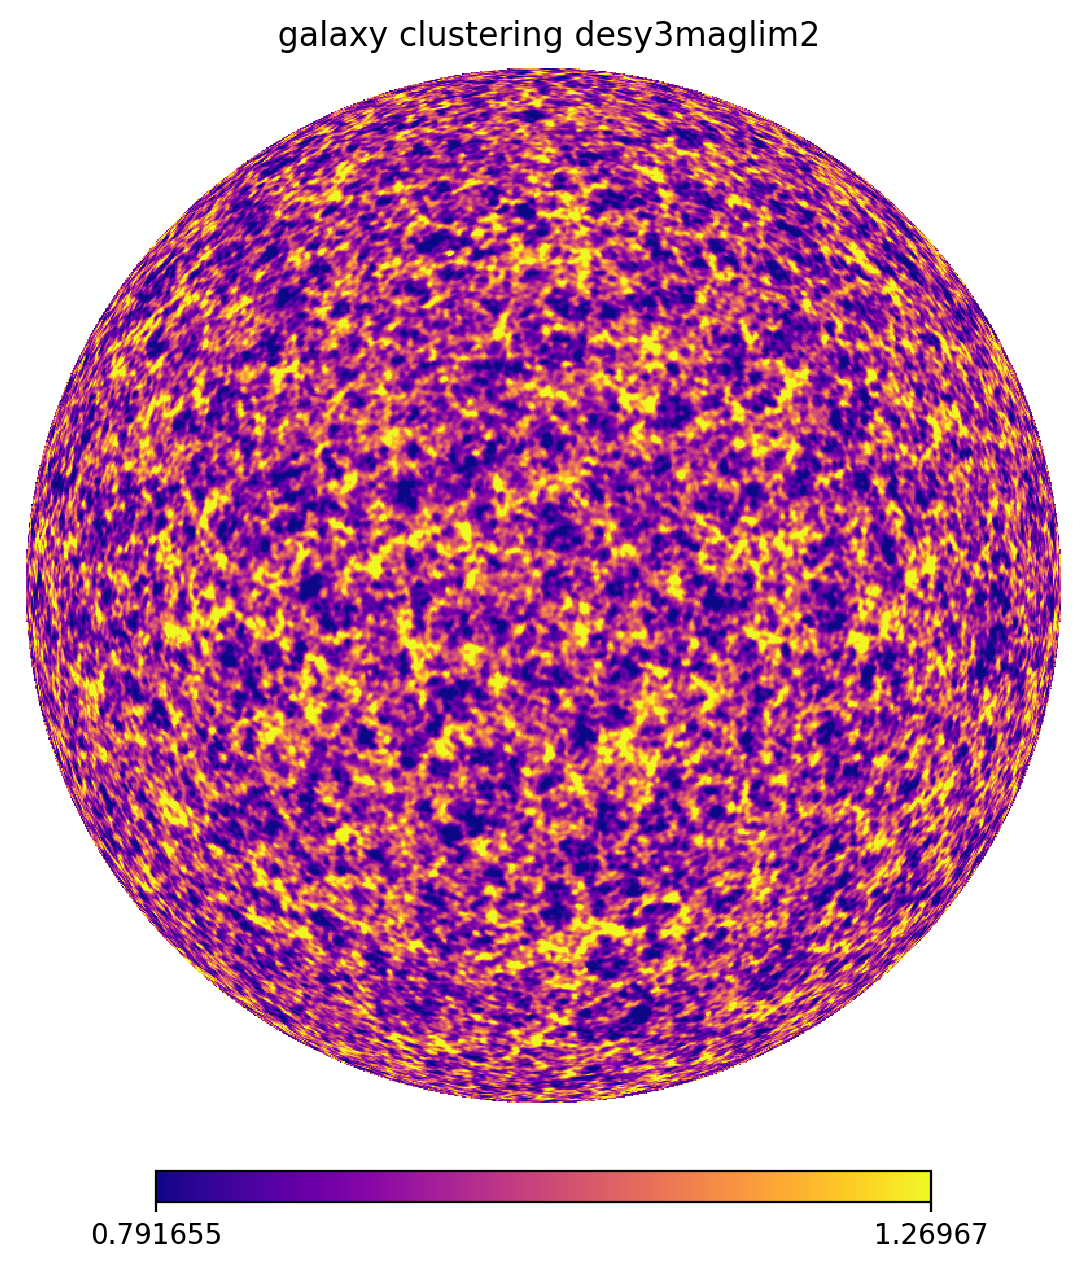

In [50]:
plot_probe_map('dg', 'desy3maglim2', maps_dmb)

In [ ]:
from ipywidgets import interactive, widgets
interactive_plot = interactive(plot_probe_map, probe=probes, sample=all_samples, maps=fixed(maps_dmb), tag=fixed('dmb'))
interactive_plot

# Load TFRecords

In [51]:
! rsync -avRh --progress {host}:/pscratch/sd/a/athomsen/DESY3/v8/linear_bias/./tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord .

receiving file list ... 
3 files to consider

sent 16 bytes  received 163 bytes  119.33 bytes/sec
total size is 1.85G  speedup is 10355130.57
